<a href="https://colab.research.google.com/github/jarek-pawlowski/advanced-machine-learning/blob/main/mnist_in_3_flavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of handwritten digits using various neural network models with PyTorch
* Multinomial classification task of images of handwritten digits (10 classes).
* The database has a training set of 60k examples, and a test set of 10k examples, each image is of 28x28 pixels size.
* The MNIST ("Modified National Institute of Standards and Technology") is the “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

## Model setup

Before we start we need to load libraries and setup the model parameters

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 50
# logging frequency
model_args['log_interval'] = 100

Let's start with loading the dataset and check how it looks like

In [3]:
# load the MINST dataset 
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 8, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


50000
10000
10000
391
torch.Size([28, 28])




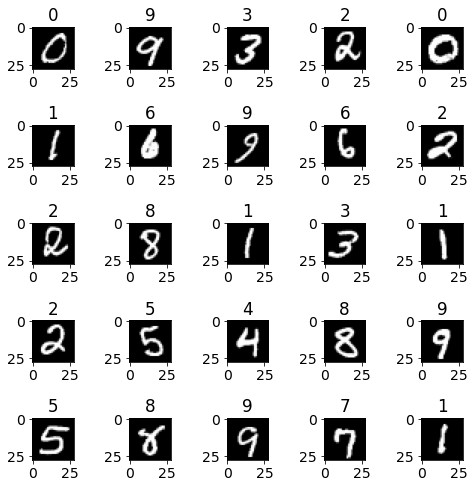

In [4]:
print(len(train_subset))
print(len(validation_subset))
print(len(test_subset)) # we have data already divided into train & validation & test subsets
print(len(train_loader)) # no of train batches
example_number = 123
print(train_subset[example_number][0][0].shape) # single item shape

fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct the NN models:
- we start with siplest single layer **perceptron** with *softmax* activation,
- then test **deep** network with some (fully-connected) *hidden* layers,
- and finally setup deep **convolutional neural network**.

In [6]:
class Perceptron(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Perceptron, self).__init__()
        # fully connected layer
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(28*28, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        # hidden layer
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch

class CNN(nn.Module):
    # this defines the structure of the CNN model
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer with 2 kernels of size 5x5
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5) 
        # 4 kernels of size 5x5
        self.conv2 = nn.Conv2d(2, 4, kernel_size=5)
        # 2D dropout
        self.conv2_drop = nn.Dropout2d()
        # fully connected layers
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # 1st layers group
        x = self.conv1(x) # resulting in 4 feature maps each of size 24x24
        x = F.max_pool2d(x, 2) # downsizing each map to 12x12
        x = F.relu(x) # standard (in CNNs) ReLU activation
        # 2nd group
        x = self.conv2(x) # resulting in 18 feature maps each of size 8x8
        # x = self.conv2_drop(x) 
        x = F.max_pool2d(x, 2) # downsizing each map to 4x4
        x = F.relu(x)
        # fully connected layers
        x = x.view(-1, 64) # 4 maps of 4x4 size gives 64 numbers
        x = self.fc1(x) # 64 -> 20
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # dropout is a type of regularization
        x = self.fc2(x) # 20 -> 10
        # softmax (multinomial classification) gives probabilities of each class
        return F.log_softmax(x, dim=1) # note that dim=0 is the number of samples in batch


And define training, testing, and plotting utils:

In [7]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

## Experiments

1. At first let's test the single-layer *Perceptron* model



Train Epoch: 1 [0/50000 (0%)]	Loss: 2.446743
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.291690
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.368716
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.301161

Train set: Average loss: 0.3747
Validation set: Average loss: 0.3165, Accuracy: 9089/10000 (91%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.410695
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.239532
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.211677
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.344253

Train set: Average loss: 0.3016
Validation set: Average loss: 0.3041, Accuracy: 9171/10000 (92%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.218611
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.343517
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.232245
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.254274

Train set: Average loss: 0.2903
Validation set: Average loss: 0.3033, Accuracy: 9192/10000 (92%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.362579
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.217758
Train Epoch: 4 [25600/5

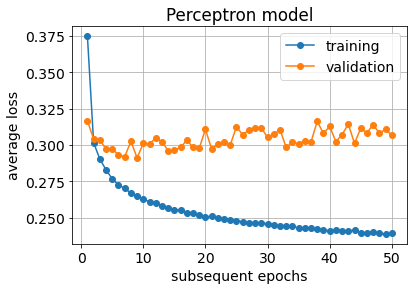

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Perceptron().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Perceptron model')

2. Now add a hidden layer to the *Perceptron* and evaluate the *Deep* model 

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.291211
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.492235
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.263598
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.229071

Train set: Average loss: 0.3994
Validation set: Average loss: 0.2517, Accuracy: 9272/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.274276
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.253321
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.212190
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.342971

Train set: Average loss: 0.2371
Validation set: Average loss: 0.2060, Accuracy: 9393/10000 (94%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.106975
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.147565
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.169521
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.225601

Train set: Average loss: 0.1972
Validation set: Average loss: 0.1994, Accuracy: 9427/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.122286
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.336024
Train Epoch: 4 [25600/5

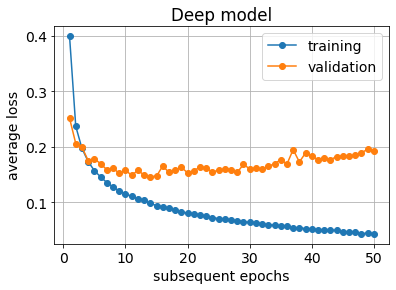

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

3. Compare these results with a deep convolutional network, which is more useful in real-world problems:

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.337983
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.117201
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.828644
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.593886

Train set: Average loss: 1.0597
Validation set: Average loss: 0.2879, Accuracy: 9181/10000 (92%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.848735
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.581835
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.638705
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.630380

Train set: Average loss: 0.6614
Validation set: Average loss: 0.2248, Accuracy: 9331/10000 (93%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.574635
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.549562
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.654454
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.605559

Train set: Average loss: 0.5951
Validation set: Average loss: 0.2103, Accuracy: 9396/10000 (94%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.679639
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.432043
Train Epoch: 4 [25600/5

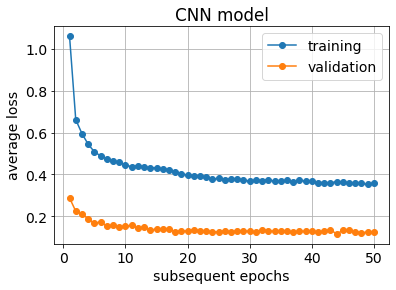

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

## Summary
* the two smallest (and simplest) models appear to be overfitted; to deal with this we need to apply some regularization,
* validation dataset is evaluated during the training (as opposed to test dataset, infered *after* the training) in order to tune the model hiperparameters (that describe e.g. the network structure, or training details),
* moment to stop trainning is a kind of hipermarameter -- by applying *early stopping* we can avoid overfitting.



## Tasks to do
* apply some regularization technique to *Deep* model in order to avoid overfitting,
* try to figure out why the validation loss for *CNN* model turns to be *lower* than the train loss (hint: turn off regularization),
* **tune one of these models to get the *Test Set Accuracy* > 99%**,
* plot the *confusion matrix* among all of the classes---which of digits are mostly confused with each other?,
* and finally prepare report.

### How the report should look like
* 1-2 page long
* shortly describe what modifications you apply
* justyfy in a few words why your improved model is so cool
* results should be presented as plots with multiline captions